In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
from torch import optim
from torch import mps
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer, minmax_scale, power_transform, scale, minmax_scale
from tqdm.auto import tqdm
# from tqdm import tqdm
import os

import lightning.pytorch as pl

from helpers.cross_sectorial import CS_DATAMODULE, CS_VID_DATAMODULE
from models.cross_sectorial import CNN_2D_LSTM, ConvLSTM_AE

# Set global seed for reproducibility in numpy, torch, scikit-learn
pl.seed_everything(42)
# torch.manual_seed(42)
# torch.mps.manual_seed(42)
# torch.backends.mps.deterministic = True
# torch.cuda.manual_seed(42)
# torch.backends.cudnn.deterministic = True
# np.random.seed(42)
%autosave 0
import warnings
warnings.filterwarnings("ignore")

c:\Users\John\miniconda3\envs\master_thesis\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")
Global seed set to 42


Autosave disabled


## Init data

In [ ]:
LEARING_RATE = 1e-4 # 1e-4 ind standard
EPOCHS = 3
BATCH_SIZE = 32 # Small batch size since we are using a small dataset

In [ ]:
data = CS_DATAMODULE(batch_size=BATCH_SIZE, lookback=12, pred_horizon=1, multistep=False, data_type="monthly")

In [ ]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

In [ ]:
data.prepare_data()
data.setup()
data.X_train_tensor.shape

In [ ]:
data.X_train_tensor.min(), data.X_train_tensor.max(), data.X_val_tensor.min(), data.X_val_tensor.max(), data.X_test_tensor.min(), data.X_test_tensor.max()

In [ ]:
# Get first iter of train loader using next
x_in, y_in = next(iter(data.train_dataloader()))

In [ ]:
x_in.shape, y_in.shape

In [ ]:
x_in.reshape(x_in.shape[0], x_in.shape[2], x_in.shape[1], 1, x_in.shape[3]).shape

## CNN LSTM

In [ ]:
convlstm = CNN_LSTM(cnn_input_size=409, 
                 lstm_input_size=1590,
                 hidden_size=3180,
                 num_layers=2, 
                 output_size=409,
                 lookback=12, 
                 dropout=0)

In [ ]:
convlstm(x_in).squeeze(1).shape

In [ ]:
from torchinfo import summary

summary(convlstm, input_size=(BATCH_SIZE, 409, 12, 159), col_names=["input_size", "output_size", "num_params", "trainable"])

In [ ]:
early_stopping = pl.callbacks.EarlyStopping(monitor="val_loss", patience=10, mode="min")
convlstm_checkpoint = pl.callbacks.ModelCheckpoint(save_top_k=1, monitor="val_loss", mode="min")

compiled_convlstm = torch.compile(convlstm, mode="reduce-overhead", backend="aot_eager")
mps.empty_cache()

convlstm_trainer = pl.Trainer(accelerator="gpu", max_epochs=EPOCHS, log_every_n_steps=1, callbacks=[early_stopping, convlstm_checkpoint], enable_checkpointing=True, enable_progress_bar=True, default_root_dir="./lightning_logs/convlstm/")
convlstm_trainer.fit(model=compiled_convlstm, datamodule=data)
mps.empty_cache()

## Conv AE

In [ ]:
x_in.shape

In [ ]:
convae = Conv2D_AE_LSTM(in_channels=409, lstm_hidden=2, lookback=12, num_features=159, batch_size=32, lr=1e-3)

In [ ]:
convae(x_in).shape

In [ ]:
from torchinfo import summary

summary(convae, input_size=(BATCH_SIZE, 409, 12, 159), col_names=["input_size", "output_size", "num_params", "trainable"])

## Video Conv JP Morgan Approach

In [2]:
BATCH_SIZE = 32
LOOKBACK = 12*21
LEARNING_RATE = 1e-5

In [3]:
data = CS_VID_DATAMODULE(batch_size=BATCH_SIZE, lookback=LOOKBACK, pred_horizon=21, multistep=True, data_type="daily", overwrite_cache=True, pred_target="return")

In [4]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='cpu')

In [5]:
from helpers.cross_sectorial import _format_tensors_cs_vid
fin_data = pd.read_parquet("./DATA/Daily/Processed/day_data_fin_tec.parquet")
X_train, X_val, X_test, y_train, y_val, y_test = _format_tensors_cs_vid(fin_data, lookback=12*21, pred_horizon=21, multistep=True, resize=None, pred_target="return")

Converting returns into video sequences:   0%|          | 0/5837 [00:00<?, ?it/s]

Formatting tensors:   0%|          | 0/5585 [00:00<?, ?it/s]

RuntimeError: shape '[1, 21, 1, 20]' is invalid for input of size 8400

In [ ]:
X_train.shape, y_train.shape

In [ ]:
X_train.shape, X_val.shape

In [ ]:
y_train.shape, y_val.shape

In [ ]:
from torchvision.transforms.functional import resize
resize(z.unsqueeze(dim=0), (64,64)).squeeze().shape

In [ ]:
z.max(), z.round().min()

In [ ]:
torch.nn.Sigmoid()(z).min(), torch.nn.Sigmoid()(z).max()

In [4]:
data.prepare_data()
data.setup()
data.X_train_tensor.shape

Converting returns into video sequences:   0%|          | 0/5837 [00:00<?, ?it/s]

Formatting tensors:   0%|          | 0/5585 [00:00<?, ?it/s]

torch.Size([5523, 252, 1, 20, 20])

In [5]:
data.X_train_tensor.shape, data.X_val_tensor.shape, data.X_test_tensor.shape

(torch.Size([5523, 252, 1, 20, 20]),
 torch.Size([1, 252, 1, 20, 20]),
 torch.Size([1, 252, 1, 20, 20]))

In [6]:
data.y_train_tensor.shape, data.y_val_tensor.shape, data.y_test_tensor.shape

(torch.Size([5523, 21, 1, 20, 20]),
 torch.Size([1, 21, 1, 20, 20]),
 torch.Size([1, 21, 1, 20, 20]))

In [ ]:
np.isnan(data.X_train_tensor.numpy()).sum()

In [ ]:
data.X_train_tensor.min(), data.X_train_tensor.max(), data.X_val_tensor.min(), data.X_val_tensor.max(), data.X_test_tensor.min(), data.X_test_tensor.max()

In [ ]:
# Get first iter of train loader using next
x_in, y_in = next(iter(data.train_dataloader()))

In [ ]:
x_in.shape, y_in.shape

In [ ]:
x_in.squeeze().shape, y_in.squeeze().shape

In [ ]:
y_in.squeeze()[-1].shape

In [ ]:
from torchvision.utils import make_grid

plt.imshow(x_in.squeeze()[-1].numpy(), cmap="gray")

In [ ]:
plt.imshow(y_in.squeeze().numpy(), cmap="gray")

In [ ]:
convlstmae = ConvLSTM_AE(
    batch_size=BATCH_SIZE,
    lookback=LOOKBACK,
    pred_horizon=1,
    hidden_dim=64,
    lr=LEARNING_RATE,)

In [ ]:
x_in.shape, y_in.squeeze().shape

In [ ]:
pred1 = convlstmae(x_in)

In [ ]:
pred1.squeeze().shape

In [ ]:
pred1.min(), pred1.max(), pred1.mean(), pred1.std()

In [ ]:
x_in[0][-1].min(), x_in[0][-1].max(), x_in[0][-1].mean(), x_in[0][-1].std(), x_in[0][-1].median()

In [ ]:
show(torchvision.utils.make_grid(x_in[0]))

In [ ]:
plt.imshow(y_in.squeeze(), cmap="gray")

In [ ]:
plt.imshow(pred1.detach().cpu().squeeze(), cmap="gray")

In [ ]:
from torchinfo import summary

summary(convlstmae, input_size=(x_in.shape), col_names=["input_size", "output_size", "num_params", "trainable"])

## ConvAELSTM

### First lets get a convautoencoder working

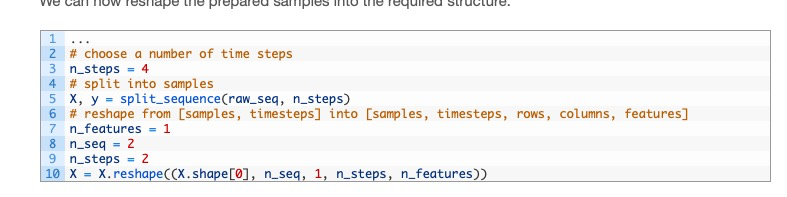

n_seq = 409 (num of companies - channels aka rows stays 1)

In [ ]:
from models.cross_sectorial import ConvLSTMCell, ConvLSTM

In [ ]:
x_in.shape

In [ ]:
u = x_in.reshape(x_in.shape[0], x_in.shape[1], 1, x_in.shape[2], x_in.shape[3])
u.shape

In [ ]:
zumba = ConvLSTMCell

In [ ]:
zumba(u)

In [ ]:
convae = Conv_AE_LSTM(channels_in=409, encoder_dim=256, lr=1e-3, batch_size=32, lookback=12, num_features=159)

In [ ]:
convae(x_in).shape

In [ ]:
from torchinfo import summary

summary(convae, input_size=(BATCH_SIZE, 409, 12, 159), col_names=["input_size", "output_size", "num_params", "trainable"])

In [ ]:
early_stopping = pl.callbacks.EarlyStopping(monitor="val_loss", patience=10, mode="min")
convae_checkpoint = pl.callbacks.ModelCheckpoint(save_top_k=1, monitor="val_loss", mode="min")

compiled_convae = torch.compile(convae, mode="reduce-overhead", backend="aot_eager")
mps.empty_cache()

convlstm_trainer = pl.Trainer(accelerator="gpu", max_epochs=200, log_every_n_steps=1, callbacks=[early_stopping, convae_checkpoint], enable_checkpointing=True, enable_progress_bar=True, default_root_dir="./lightning_logs/convae/")
convlstm_trainer.fit(model=compiled_convae, datamodule=data)
mps.empty_cache()

In [ ]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

In [ ]:
print(f"Best model path: {convlstm_checkpoint.best_model_path}")
print(f"Best model score: {convlstm_checkpoint.best_model_score}")

In [ ]:
# /Users/johnbergmann/Developer/Master-Thesis/lightning_logs/version_29/checkpoints/epoch=5493-step=49446.ckpt
# lightning_logs/convae/lightning_logs/version_22/checkpoints/epoch=8-step=306.ckpt
best_model = ConvLSTM_AE.load_from_checkpoint(checkpoint_path="lightning_logs/convae/lightning_logs/version_46/checkpoints/epoch=18-step=171.ckpt")

In [ ]:
X_val_tensor = data.X_val_tensor
y_val_tensor = data.y_val_tensor

In [ ]:
best_model.eval()
with torch.inference_mode():
    y_pred = best_model(X_val_tensor.to("cpu")).cpu().detach().numpy()

In [ ]:
y_val_tensor.shape, y_pred.shape

In [ ]:
plt.imshow(y_val_tensor.squeeze(), cmap="gray")

In [ ]:
plt.imshow(y_pred.squeeze(), cmap="gray")

In [ ]:
X_val_tensor[0].shape

In [ ]:
from torchvision.utils import make_grid
import torchvision.transforms.functional as F
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

show(make_grid(X_val_tensor[0]))

In [ ]:
plt.imshow(y_pred.squeeze(), cmap="gray")

In [ ]:
# Plot predictions vs actuals

plt.figure(figsize=(15, 6))
plt.plot(y_val_tensor.squeeze(), label='actual')
plt.plot(y_pred.squeeze(), label='predicted')
plt.legend()
plt.show();

In [ ]:
# R2 score and MAPE
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
print(f"R2 score: {r2_score(y_val_tensor.squeeze(), y_pred.squeeze()):.4f}")
print(f"MAPE: {mean_absolute_percentage_error(y_val_tensor, y_pred):.4%}")
print(f"MAE: {mean_absolute_error(y_val_tensor, y_pred):.4f}")

In [ ]:
# Show without scientific notation
np.set_printoptions(suppress=True)
np.round(y_pred.squeeze(), 2)

In [ ]:
y_val

create 2 cluster

# BAZINGA!